# HOMEWORK #4: Parallelism

Carina Cheng

In [53]:
# Imports
from random import uniform
from time import time
from math import sqrt
import numpy as np
from multiprocessing import Pool
import ipyparallel as ipp
from ipyparallel import Client
import matplotlib.pyplot as plt

# Global variables
darts = np.logspace(1,7,20,dtype='int') # number of darts to throw, ranging from 10^1 to 10^7
nsims = 10 # number of simulations to run (for error computation)

### Function throw_dart ###
# Input: number of darts to throw
# Outputs: number of darts that land in the circle
# Description: 
#   - throws darts randomly on a unit-square and computes whether it lands in the unit-circle

def throw_dart(num_darts):
    from random import uniform # need imports here for IPcluster
    from math import sqrt
    num_darts_in_circle = 0 # start with 0 darts in the circle
    for n in range(num_darts):
        x,y = uniform(0,1), uniform(0,1) # uniformly drawn number between 0 and 1
        if sqrt((x - 0.5)**2 + (y - 0.5)**2) <= 0.5: # if inside the circle
            num_darts_in_circle += 1
    return num_darts_in_circle

### Function run_sim ###
# Input: number of simulations to run, and which parallelization method to use
# Outputs: run times, rates, and approximated pi's (#sims, #darts)
# Description:
#  - runs multiple simulations, each with a range of number of darts thrown
#  - saves simulation time, rate, and approximated pi values for each sim

def run_sim(nsims, serial=False, multi=False, ipc=False):
    sim_times, sim_rates, sim_pis = [], [], []
    for sim in range(nsims): # multiple simulations
        print('Simulation',sim+1,'/',nsims)
        times, rates, pis = [], [], []
        for nn,num in enumerate(darts):
            #print(' ',nn+1,'/',len(darts),': Throwing',num,'darts')
            if serial: t,r,p = serial_pi(num)
            if multi: t,r,p = multi_pi(num)
            if ipc: t,r,p = ipc_pi(num)
            times.append(t)
            rates.append(r)
            pis.append(p)
        sim_times.append(times)
        sim_rates.append(rates)
        sim_pis.append(pis)
    return sim_times, sim_rates, sim_pis

# Simple Serial

In [54]:
### Function serial_pi ###
# Input: number of darts to throw
# Outputs: tuple: (simulation time, simulation rate, approximated pi value)
# Description: 
#   - throws a dart randomly on a unit-square and computes whether it lands in the unit-circle
#   - computes the time it takes to run the simulation

def serial_pi(num_darts):
    start_time = time() # start time
    num_darts_in_circle = throw_dart(num_darts)
    end_time = time() # end time
    serial_time = end_time - start_time # time for serial program
    pi_approx = 4 * num_darts_in_circle / float(num_darts)
    return (serial_time, num_darts/serial_time, pi_approx)

### Run simulation ###
serial_times, serial_rates, serial_pis = run_sim(nsims, serial=True)

Simulation 1 / 10
Simulation 2 / 10
Simulation 3 / 10
Simulation 4 / 10
Simulation 5 / 10
Simulation 6 / 10
Simulation 7 / 10
Simulation 8 / 10
Simulation 9 / 10
Simulation 10 / 10


# Multiprocessing

In [8]:
### Function throw_dart_multi ###
# Input: dart number
# Outputs: value 1 (if dart lands on the circle) or value 0 (if it doesn't)
# Description: 
#   - throws a dart randomly on a unit-square and computes whether it lands in the unit-circle

def throw_dart_multi(dart):
    x,y = uniform(0,1), uniform(0,1) # uniformly drawn number between 0 and 1
    if sqrt((x - 0.5)**2 + (y - 0.5)**2) <= 0.5: # if inside the circle
        return 1
    else: return 0
    
### Function multi_pi ###
# Input: number of darts to throw
# Outputs: tuple: (simulation time, simulation rate, approximated pi value)
# Description: 
#   - uses multiprocessing to parallelize the process of throwing darts
#   - computes the time it takes to run the simulation

def multi_pi(num_darts):
    num_darts_in_circle = 0 # start with 0 darts in the circle
    start_time = time() # start time
    pool = Pool(processes=2) # 2 cores
    results = list(pool.map(throw_dart_multi,range(num_darts))) # parallelize throwing darts
    end_time = time() # end time
    multi_time = end_time - start_time # time for multi-processing program
    pool.terminate()
    del pool
    num_darts_in_circle = sum(results)
    pi_approx = 4 * num_darts_in_circle / float(num_darts)
    return (multi_time, num_darts/multi_time, pi_approx)

### Run simulation ###
multi_times, multi_rates, multi_pis = run_sim(nsims, multi=True)

Simulation 1 / 10
Simulation 2 / 10
Simulation 3 / 10
Simulation 4 / 10
Simulation 5 / 10
Simulation 6 / 10
Simulation 7 / 10
Simulation 8 / 10
Simulation 9 / 10
Simulation 10 / 10


# IPCluster

In [55]:
### Function ipc_pi ###
# Input: number of darts to throw
# Outputs: tuple: (simulation time, simulation rate, approximated pi value)
# Description: 
#   - uses IPcluster to parallelize the process of throwing darts
#   - determines the number of darts each core will throw based on the total number of darts and number of cores
#   - computes the time it takes to run the simulation

def ipc_pi(num_darts):
    start_time = time() # start time
    # calculate number of darts for each core to throw (divide it up as evenly as possible)
    groups = [len(l) for l in [np.arange(num_darts)[i::ncores] for i in range(ncores)]] 
    view = rc.load_balanced_view()
    results = list(view.map(throw_dart,groups)) # parallelize throwing darts
    num_darts_in_circle = np.sum(results)
    end_time = time() # end time
    ipc_time = end_time - start_time # time for IPcluster program
    pi_approx = 4 * num_darts_in_circle / float(num_darts)
    return (ipc_time, num_darts/ipc_time, pi_approx)

### Run simulation ###
rc = Client()
rc.block = True
ncores = 4 # XXX hard-coded and matches command: $ ipcluster start -n 4
ipc_times, ipc_rates, ipc_pis = run_sim(nsims, ipc=True)

/anaconda2/envs/conda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@MacBook-Pro-2.local')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Simulation 1 / 10
Simulation 2 / 10
Simulation 3 / 10
Simulation 4 / 10
Simulation 5 / 10
Simulation 6 / 10
Simulation 7 / 10
Simulation 8 / 10
Simulation 9 / 10
Simulation 10 / 10


# Plotting

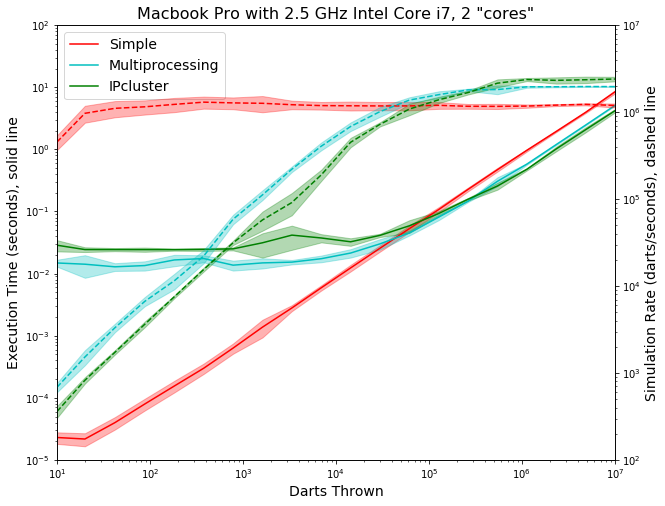

In [57]:
%matplotlib inline

# Description:
#  - for each of the programs (serial, multi, IPcluster):
#    - plots number of darts vs. simulation time (mean of simulations, with errors as std)
#    - plots number of darts vs. simulation rate (mean of simulations, with errors as std)

fig, ax1 = plt.subplots(figsize=(10,8))

ax1.loglog(darts, np.mean(serial_times,axis=0), 'r-', label='Simple')
ax1.fill_between(darts, np.mean(serial_times,axis=0)-np.std(serial_times,axis=0), \
                 np.mean(serial_times,axis=0)+np.std(serial_times,axis=0), color='r', alpha=0.3)
ax1.loglog(darts, np.mean(multi_times,axis=0), 'c-', label='Multiprocessing')
ax1.fill_between(darts, np.mean(multi_times,axis=0)-np.std(multi_times,axis=0), \
                 np.mean(multi_times,axis=0)+np.std(multi_times,axis=0), color='c', alpha=0.3)
ax1.loglog(darts, np.mean(ipc_times,axis=0), 'g-', label='IPcluster')
ax1.fill_between(darts, np.mean(ipc_times,axis=0)-np.std(ipc_times,axis=0), \
                 np.mean(ipc_times,axis=0)+np.std(ipc_times,axis=0), color='g', alpha=0.3)
ax1.set_xlabel('Darts Thrown', fontsize=14)
ax1.set_ylabel('Execution Time (seconds), solid line', fontsize=14)
ax1.set_ylim(1e-5,1e2)

ax2 = ax1.twinx()
ax2.loglog(darts, np.mean(serial_rates,axis=0), 'r--')
ax2.fill_between(darts, np.mean(serial_rates,axis=0)-np.std(serial_rates,axis=0), \
                 np.mean(serial_rates,axis=0)+np.std(serial_rates,axis=0), color='r', alpha=0.3)
ax2.loglog(darts, np.mean(multi_rates,axis=0), 'c--')
ax2.fill_between(darts, np.mean(multi_rates,axis=0)-np.std(multi_rates,axis=0), \
                 np.mean(multi_rates,axis=0)+np.std(multi_rates,axis=0), color='c', alpha=0.3)
ax2.loglog(darts, np.mean(ipc_rates,axis=0), 'g--')
ax2.fill_between(darts, np.mean(ipc_rates,axis=0)-np.std(ipc_rates,axis=0), \
                 np.mean(ipc_rates,axis=0)+np.std(ipc_rates,axis=0), color='g', alpha=0.3)
ax2.set_ylabel('Simulation Rate (darts/seconds), dashed line', fontsize=14)
ax2.set_xlim(1e1,1e7)
ax2.set_ylim(1e2,1e7)
ax1.legend(prop={'size':14}, loc='best')
ax1.set_title('Macbook Pro with 2.5 GHz Intel Core i7, 2 "cores"', fontsize=16)

plt.show()